In [4]:
# Why LAB?  The L channel is brightness alone, and the a/b channels capture color.
!pip install scikit-image

import os
import glob
import numpy as np
import cv2
from skimage.color import rgb2lab, lab2rgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, UpSampling2D, Input, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [5]:
# Choose a manageable size for all images
IMG_HEIGHT = 256
IMG_WIDTH  = 256

def load_image(path):
    """Read an image from disk, convert to RGB and resize."""
    img = cv2.imread(path)                 # BGR by default
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    return img

def preprocess(img):
    """
    Convert RGB to LAB, normalize:
      - L channel to [0,1]
      - a/b channels to [-1,1]
    """
    lab = rgb2lab(img).astype('float32')
    L  = lab[..., 0] / 100.0               # 0→100 → 0→1
    ab = lab[..., 1:] / 128.0              # approximately -128→127 → -1→1
    return L[..., np.newaxis], ab


In [6]:
# 3. Load your dataset (match every file with "jpj" in its name)
import glob
from sklearn.model_selection import train_test_split

# 3.1—Grab every file under /content/ whose filename contains "jpj"
#      If your files are really .jpj (not a typo), this will catch them.
#      If they’re actually .jpg, you might want: glob.glob('/content/*.jpg')
paths = glob.glob('/content/*jpg*')

# 3.2—Preallocate lists for L and ab channels
L_list, ab_list = [], []

for p in paths:
    # 3.2.1—Read, convert BGR→RGB, and resize
    img = load_image(p)         # uses your helper: cv2 → RGB → fixed size

    # 3.2.2—Convert to LAB and normalize each channel
    L, ab = preprocess(img)     # splits into L∈[0,1] and ab∈[-1,1]

    # 3.2.3—Accumulate
    L_list.append(L)
    ab_list.append(ab)

# 3.3—Stack into numpy arrays of shape (N, H, W, C)
L_array  = np.stack(L_list, axis=0)   # → (num_images, H, W, 1)
ab_array = np.stack(ab_list, axis=0)  # → (num_images, H, W, 2)

# 3.4—Split into train/test so we can both learn and evaluate generalization
X_train, X_test, Y_train, Y_test = train_test_split(
    L_array, ab_array,
    test_size=0.2,
    random_state=42
)

print(f"Found {len(paths)} total images; "
      f"Training on {X_train.shape[0]}, testing on {X_test.shape[0]}")


Found 84 total images; Training on 67, testing on 17


In [7]:
# 4. Build (or re‑build) the colorizer model
#    This encoder‑decoder architecture compresses the grayscale input
#    then learns to upsample back to full resolution in the ab channels.

from tensorflow.keras.layers import Conv2D, UpSampling2D, Input, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_colorizer_model():
    inp = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1), name='L_input')

    # --- Encoder: downsample and extract features ---
    x = Conv2D(64, (3,3), strides=2, padding='same')(inp)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3,3), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3,3), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # --- Decoder: upsample back to (H,W) and predict 2 color channels ---
    x = UpSampling2D((2,2))(x)
    x = Conv2D(128, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = UpSampling2D((2,2))(x)
    x = Conv2D(64, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = UpSampling2D((2,2))(x)
    # tanh activation keeps outputs in [-1,1], matching our normalized ab range
    out = Conv2D(2, (3,3), padding='same', activation='tanh', name='ab_output')(x)

    return Model(inputs=inp, outputs=out)

model = build_colorizer_model()
model.compile(optimizer=Adam(1e-4), loss='mse')  # MSE on ab channels
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ L_input (InputLayer)            │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ab_output (Conv2D)              │ (None, 256, 256, 2)    │         1,154 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 742,210 (2.83 MB)

 Trainable params: 740,930 (2.83 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [8]:
# 5. Train the model
#    With only ~84 images, overfitting is a real risk—monitor train vs val loss.

EPOCHS     = 100
BATCH_SIZE = 8

history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)


Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 62s 5s/step - loss: 0.3091 - val_loss: 0.0149
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 77s 5s/step - loss: 0.1717 - val_loss: 0.0159
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - loss: 0.0978 - val_loss: 0.0161
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 92s 5s/step - loss: 0.0624 - val_loss: 0.0152
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 74s 5s/step - loss: 0.0411 - val_loss: 0.0149
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 83s 5s/step - loss: 0.0318 - val_loss: 0.0160
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 81s 5s/step - loss: 0.0291 - val_loss: 0.0176
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 46s 5s/step - loss: 0.0248 - val_loss: 0.0176
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 81s 5s/step - loss: 0.0224 - val_loss: 0.0186
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 83s 5s/step - loss: 0.0192 - val_loss: 0.0196
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 84s 5s/step - loss: 0.0204 - val_loss: 0.0220
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 80s 5s/step - loss: 0.0181 - val_loss: 0.0210
E

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step


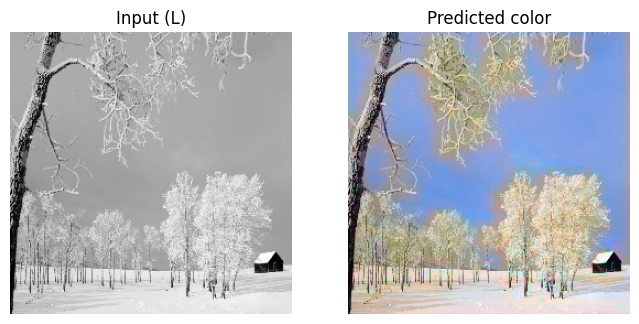

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


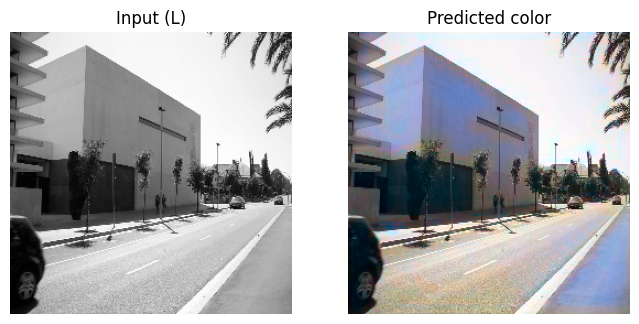

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


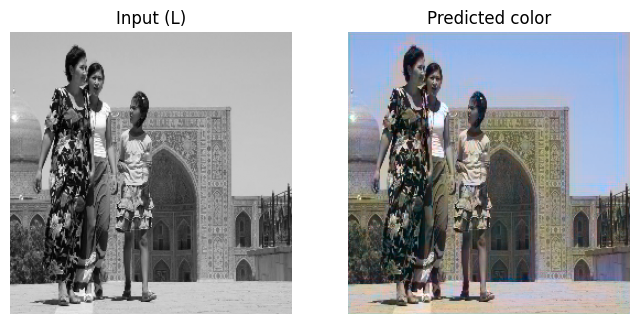

In [9]:
# 6. Colorize & visualize on held‑out test images

def display_colorization(L_gray, ab_pred):
    # 6.1—Denormalize channels back to LAB ranges
    L  = L_gray * 100.0
    ab = ab_pred * 128.0

    # 6.2—Reconstruct LAB image
    lab = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), dtype='float32')
    lab[..., 0]  = L[..., 0]
    lab[..., 1:] = ab

    # 6.3—Convert to RGB and clip
    rgb = np.clip(lab2rgb(lab), 0, 1)

    # 6.4—Plot side‑by‑side
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(L_gray.squeeze(), cmap='gray')
    plt.title('Input (L)')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(rgb)
    plt.title('Predicted color')
    plt.axis('off')
    plt.show()

# Sample a few test cases at random
for idx in np.random.choice(len(X_test), 3, replace=False):
    L_in   = X_test[idx:idx+1]
    ab_out = model.predict(L_in)
    display_colorization(L_in[0], ab_out[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


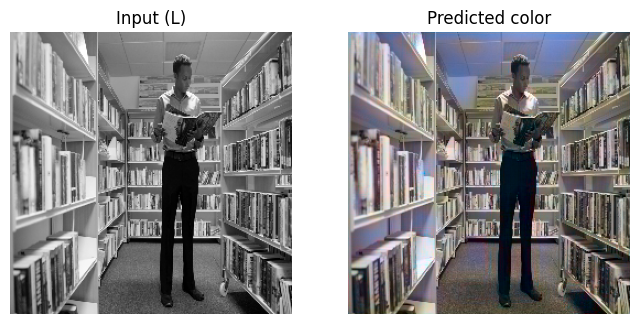

→ saved: colorized_results/colorized_009.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


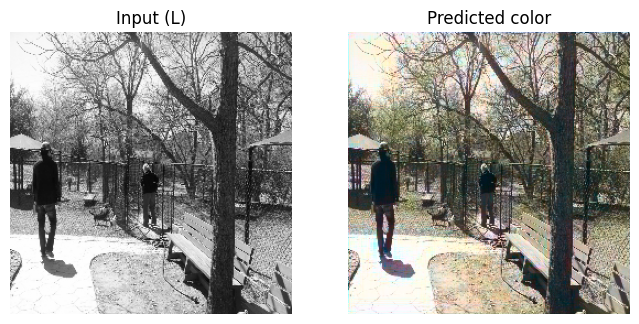

→ saved: colorized_results/colorized_006.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


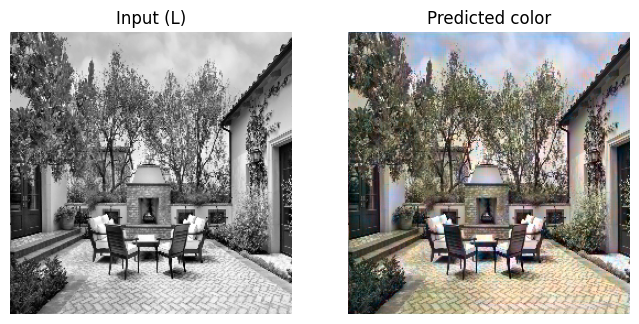

→ saved: colorized_results/colorized_002.png


In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import lab2rgb

def display_colorization(L_gray, ab_pred, save_path=None):
    """
    Displays the L→RGB colorization side‑by‑side, and if save_path is provided,
    also writes the figure out to that file.

    Args:
        L_gray    (np.ndarray): Single‑channel input, normalized to [0,1].
        ab_pred   (np.ndarray): Predicted a/b channels, normalized to [-1,1].
        save_path (str, optional): Path (including filename) to save the PNG.
    """
    # 6.1—Denormalize channels back to LAB ranges
    # L was scaled to [0,1]; multiply to get [0,100]
    L  = L_gray * 100.0
    # a/b were scaled to [-1,1]; multiply to get [-128,128]
    ab = ab_pred * 128.0

    # 6.2—Reconstruct LAB image
    lab = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), dtype='float32')
    lab[..., 0]  = L[..., 0]
    lab[..., 1:] = ab

    # 6.3—Convert to RGB and clip values to [0,1]
    rgb = np.clip(lab2rgb(lab), 0, 1)

    # 6.4—Create the matplotlib figure
    fig = plt.figure(figsize=(8, 4))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(L_gray.squeeze(), cmap='gray')
    ax1.set_title('Input (L)')
    ax1.axis('off')

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.imshow(rgb)
    ax2.set_title('Predicted color')
    ax2.axis('off')

    # 6.5—Save to disk if desired
    if save_path:
        # Ensure directory exists so save doesn't error
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        # Save the current figure. bbox_inches='tight' trims whitespace.
        fig.savefig(save_path, bbox_inches='tight', dpi=150)

    # 6.6—Show in‐notebook
    plt.show()
    # 6.7—Close to free memory
    plt.close(fig)

# Usage: sample a few and save them
output_dir = 'colorized_results'
for idx in np.random.choice(len(X_test), 3, replace=False):
    L_in   = X_test[idx:idx+1]         # grab one L-channel
    ab_out = model.predict(L_in)      # predict a/b channels

    # build a filename for each example
    fname = f'colorized_{idx:03d}.png'
    save_path = os.path.join(output_dir, fname)

    # call our updated function with save_path
    display_colorization(L_in[0], ab_out[0], save_path=save_path)

    print(f"→ saved: {save_path}")


In [11]:
from tensorflow.keras.models import load_model

# --- After training your model ---
# `model` is your trained Keras Model instance.

# 1.1—Save the full model (architecture, weights, compile‐info)
model.save('my_colorizer_model.h5')
# └─ Saves:
#     • model topology (layers, config)
#     • learned weights
#     • optimizer state (so you can .fit() further if desired)

# --- Later, in a fresh script/session ---
# 1.2—Reload it exactly as it was
model = load_model('my_colorizer_model.h5')
# └─ You can now call model.predict(), model.evaluate(), or even
#    resume training with model.fit() without redefining its code.


TypeError: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}

In [12]:
# — After training your model —
# Save in Keras v3 “.keras” format (architecture + weights + compile state)
model.save('my_colorizer_model.keras')

# …later, in a fresh session…
from tensorflow.keras.models import load_model

# This should now load without any “mse” lookup errors:
model = load_model('my_colorizer_model.keras')


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 24 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
